<a href="https://colab.research.google.com/github/monu322/CE888/blob/main/Assg2/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pyLDAvis

In [4]:
import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import warnings
from pprint import pprint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#importing sentiment data
tweets=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt', header=None)
print('Training tweets', tweets.shape)

tweets_sentiment=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt', header=None)
print('Training labels', tweets_sentiment.shape)

tweets_test=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt', header=None)
print('Test tweets',tweets_test.shape)

tweets_test_sentiment=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt', header=None)
print('Test labels',tweets_test_sentiment.shape)

Training tweets (45615, 2)
Training labels (45615, 1)
Test tweets (12284, 1)
Test labels (12284, 1)


In [34]:
tweets.columns = ['text', 'user']
tweets_test.columns = ['text']

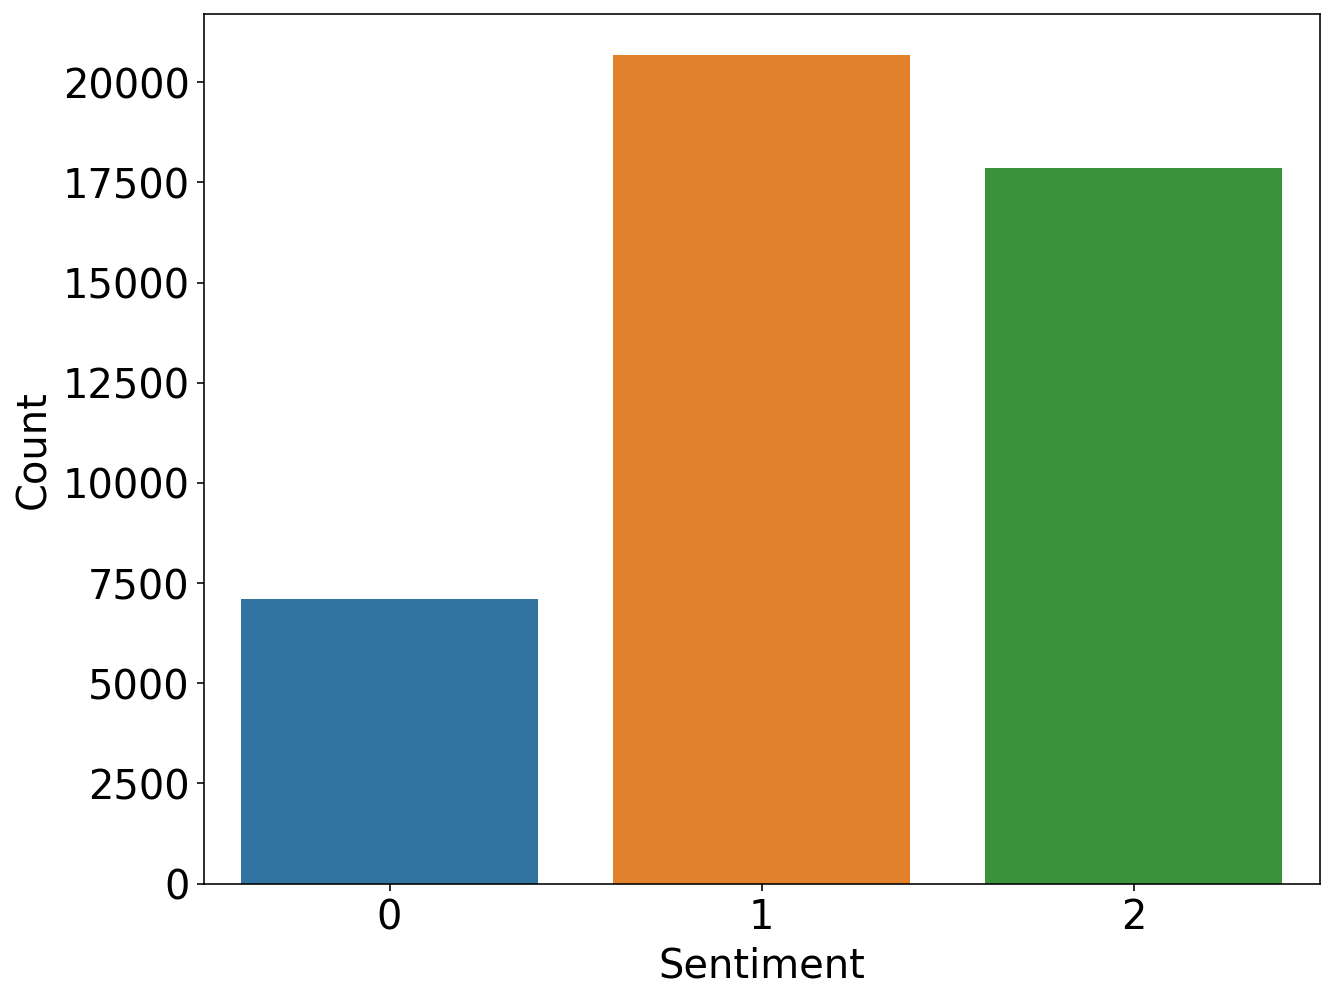

In [16]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.countplot(0, data = tweets_sentiment)
plt.ylabel('Count')
plt.xlabel('Sentiment');

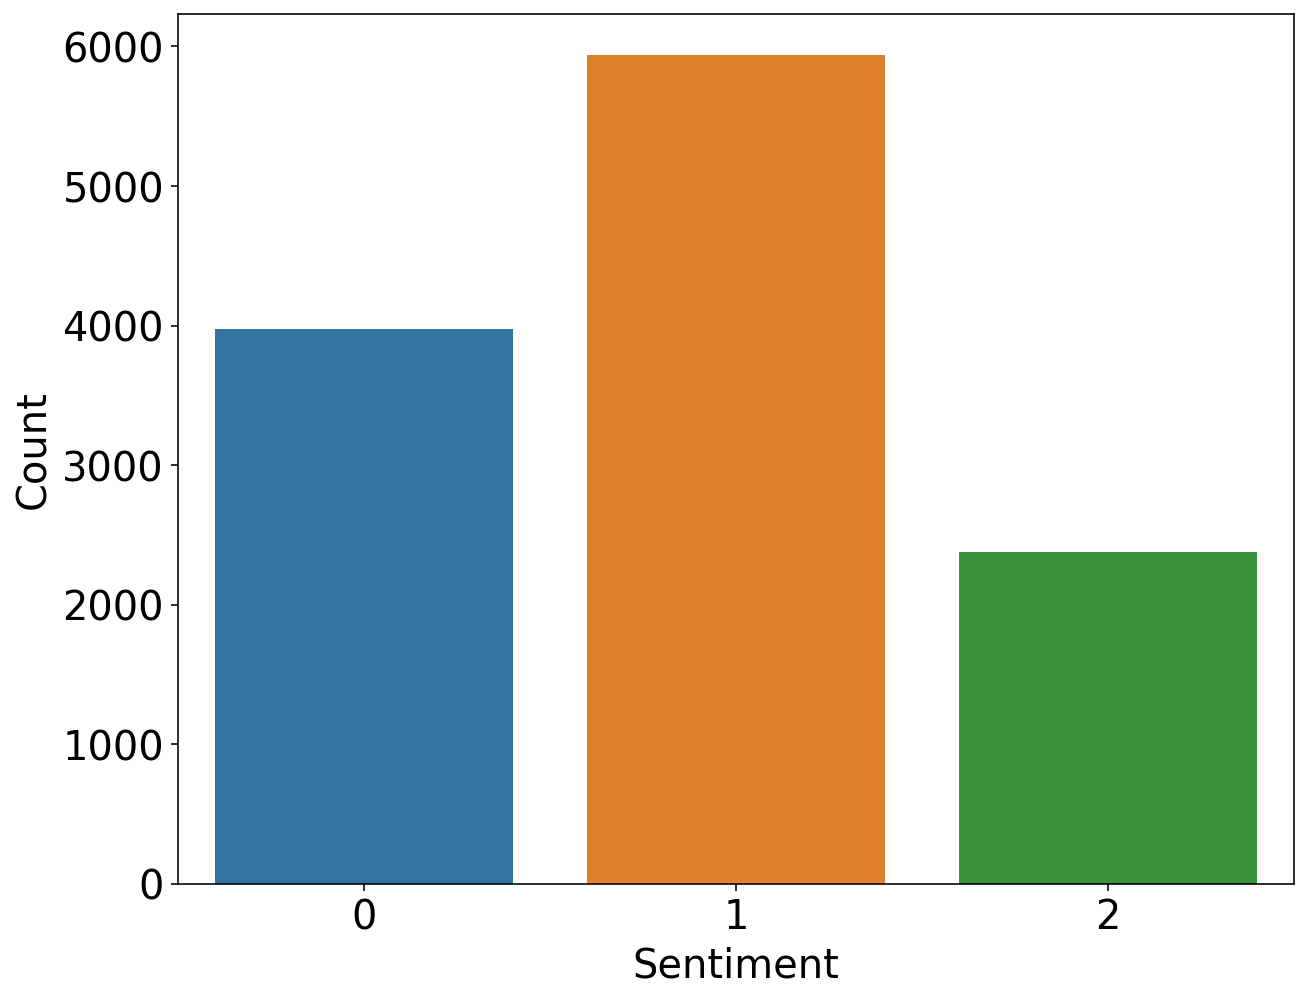

In [35]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.countplot(0, data = tweets_test_sentiment)
plt.ylabel('Count')
plt.xlabel('Sentiment');

In [70]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(tweets)

In [65]:
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4,
                           num_topics=10,
                           id2word=train_id2word4,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)

In [67]:
coherence_model_lda = CoherenceModel(model=lda_train4, texts=bigram_train4, dictionary=train_id2word4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.25328598539159974

In [68]:
lda_train4.print_topics(40,num_words=15)[:40]

[(0,
  '0.014*"friday" + 0.014*"th" + 0.009*"ice_cube" + 0.009*"rt_user" + 0.009*"thursday" + 0.009*"says" + 0.008*"nfl" + 0.008*"st" + 0.008*"sunday" + 0.008*"tom_brady" + 0.007*"via_user" + 0.007*"said" + 0.007*"times" + 0.007*"scott_walker" + 0.006*"music"'),
 (1,
  '0.124*"user" + 0.049*"tomorrow" + 0.022*"see" + 0.016*"going" + 0.015*"get" + 0.013*"come" + 0.012*"go" + 0.010*"friday" + 0.010*"sunday" + 0.010*"tonight" + 0.009*"saturday" + 0.009*"night" + 0.009*"day" + 0.008*"work" + 0.007*"amp"'),
 (2,
  '0.016*"sunday" + 0.014*"monday_night" + 0.013*"murray" + 0.012*"amp" + 0.012*"raw" + 0.011*"john_cena" + 0.010*"match" + 0.009*"seth_rollins" + 0.009*"real_madrid" + 0.008*"wwe" + 0.008*"star" + 0.008*"brock_lesnar" + 0.007*"full" + 0.007*"th" + 0.007*"video"'),
 (3,
  '0.079*"tomorrow" + 0.045*"day" + 0.031*"going" + 0.016*"night" + 0.013*"happy" + 0.013*"concert" + 0.012*"gonna" + 0.010*"watch" + 0.010*"see" + 0.010*"go" + 0.010*"school" + 0.009*"get" + 0.009*"today" + 0.009*"p

In [71]:
train_vecs = []

for i in range(len(tweets)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    train_vecs.append(topic_vec)

print("Document topic matrix of 1st review: ", train_vecs[0])

Document topic matrix of 1st review:  [0.012503136, 0.012508917, 0.012500192, 0.012500156, 0.012504789, 0.61343026, 0.012503943, 0.012501038, 0.28654647, 0.012501149]


In [72]:
import warnings
warnings.filterwarnings('ignore')

X = np.array(train_vecs)
y = np.array(tweets_sentiment[0])

kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1,  = [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    #Mini-Batch SGD
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    # SGD Modified Huber
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='weighted'))

print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')
print(f'SGD Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')


Logistic Regression Val f1: 0.436 +- 0.003
Logisitic Regression SGD Val f1: 0.461 +- 0.004
SGD Huber Val f1: 0.301 +- 0.082


In [73]:
test_corpus4, test_id2word4, bigram_test4 = get_corpus(tweets_test)

In [75]:
test_vecs = []

for i in range(len(tweets_test)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    test_vecs.append(topic_vec)

print("Document topic matrix of 1st review: ", test_vecs[0])

Document topic matrix of 1st review:  [0.012503138, 0.012508847, 0.012500193, 0.012500157, 0.012504787, 0.6134154, 0.0125039425, 0.012501039, 0.2865613, 0.012501151]


In [76]:
from sklearn import svm

X_test = np.array(test_vecs)
y_test = np.array(tweets_test_sentiment[0])

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X, y)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [78]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.3223989301986505
